# Warehouse Storage Optimization

## 1. Storage Location Assignment

### Distance Matrix and Weights




In [12]:
import pandas as pd

# Required storage spaces needed data S_i
storage_spaces = {"A" : 3, "B" : 5, "C" : 2, "D" : 6}
total_spaces = sum(storage_spaces.values())

# Frequency of trips data f_ik
frequency = {"IO Point 1" : {"A" : 150, "B" : 60, "C" : 96, "D" : 175},
            "IO Point 2" : {"A" : 25, "B" : 200, "C" : 15, "D" : 135},
            "IO Point 3" : {"A" : 88, "B" : 150, "C" : 85, "D" : 90},
}
frequency_df = pd.DataFrame(frequency).loc[["A", "B", "C", "D"]]

# Cost data c_ik
cost = {"IO Point 1" : {"A" : 6, "B" : 7, "C" : 4, "D" : 15},
        "IO Point 2" : {"A" : 5, "B" : 3, "C" : 7, "D" : 8},
        "IO Point 3" : {"A" : 5, "B" : 6, "C" : 9, "D" : 12},
}
cost_df = pd.DataFrame(cost).loc[["A", "B", "C", "D"]]

# Define the IO points coordinates
io_points = {1: (2.5, 0.5), 2: (0.5, 2.5), 3: (2.5, 4.5)}

storage_locations = {}
idx = 1
for y in range(4, 0, -1):
    for x in range(1,5):
        storage_locations[idx] = (x, y)
        idx += 1

#print(storage_locations)

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Calculate distance matrix d_kj
distance_matrix = pd.DataFrame(index=io_points.keys(), columns=storage_locations.keys())

for k, io_coord in io_points.items():
    for j, storage_coord in storage_locations.items():
        distance_matrix.loc[k, j] = manhattan_distance(io_coord, storage_coord)

print("Distance Matrix (d_kj): \n")
print(distance_matrix)

# Calculate weight matrix w_ij
items = ["A", "B", "C", "D"]
weights_matrix = pd.DataFrame(index=items, columns=storage_locations.keys())

for i in items:
    # denominator S_i
    S_i = sum(
        cost_df.loc[i, f"IO Point {k}"] * frequency_df.loc[i, f"IO Point {k}"]
        for k in io_points.keys()
    )

    for j in storage_locations.keys():
        numerator = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            numerator += c_ik * f_ik * d_kj

        weights_matrix.loc[i, j] = numerator / S_i if S_i != 0 else 0

print("Weight matrix w_ij (items x storage locations):")
print(weights_matrix)


Distance Matrix (d_kj): 

    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  
Weight matrix w_ij (items x storage locations):
         1         2         3         4         5         6         7   \
A  3.843003  3.013652  3.098976  4.098976  3.443686  2.614334  2.699659   
B   2.65625   2.28125   2.59375   3.59375   2.59375   2.21875   2.53125   
C   2.91866  2.086124  2.169856  3.169856  3.138756   2.30622  2.389952   
D  3.645768  3.097179  3.322884  4.322884  3.097179  2.548589  2.774295   

         8         9         10        11        12        13        14  \
A  3.699659  3.129693  2.300341  2.385666  3.385666  2.901024  2.071672   
B   3.53125   2.84375   2.46875   2.78125  

### Mathematical Model (SLAP)

Cost matrix (items x storage locations):
         1         2         3         4         5         6         7   \
A  3.843003  3.013652  3.098976  4.098976  3.443686  2.614334  2.699659   
B  2.656250  2.281250  2.593750  3.593750  2.593750  2.218750  2.531250   
C  2.918660  2.086124  2.169856  3.169856  3.138756  2.306220  2.389952   
D  3.645768  3.097179  3.322884  4.322884  3.097179  2.548589  2.774295   

         8         9         10        11        12        13        14  \
A  3.699659  3.129693  2.300341  2.385666  3.385666  2.901024  2.071672   
B  3.531250  2.843750  2.468750  2.781250  3.781250  3.406250  3.031250   
C  3.389952  3.442584  2.610048  2.693780  3.693780  3.830144  2.997608   
D  3.774295  2.774295  2.225705  2.451411  3.451411  2.677116  2.128527   

         15        16  
A  2.156997  3.156997  
B  3.343750  4.343750  
C  3.081340  4.081340  
D  2.354232  3.354232  
Optimal total travel cost: 42
Assigned counts: {'B': 5, 'C': 2, 'A': 3, 'D': 6}
Slot ->

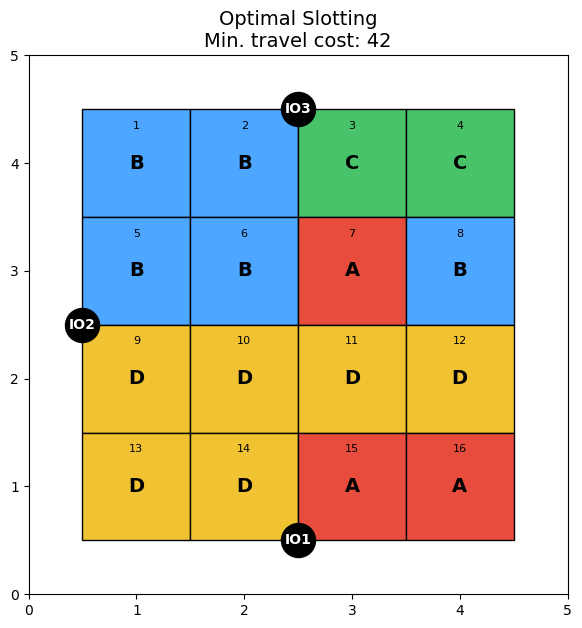

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Grid and centers
slots = {}
n = 1
for y in range(4, 0, -1):
    for x in range(1, 5):
        slots[n] = (x, y)
        n += 1

centers = {s: (x - 0.5, y - 0.5) for s, (x, y) in slots.items()}

# I/O coordinates
io_coords = {
    1: (2.5, 0.5),   # IO1
    2: (0.5, 2.5),   # IO2
    3: (2.5, 4.5),   # IO3
}

# Building cost matrix
slot_list = list(storage_locations.keys())
cost_matrix = weights_matrix.astype(float)   

#cost_matrix = pd.DataFrame(index=items, columns=slot_list, dtype=float)
#for i in items:
    #for j in slot_list:
        #total_cost = 0
        #for k in io_points.keys():
            #f_ik = frequency_df.loc[i, f"IO Point {k}"]
            #c_ik = cost_df.loc[i, f"IO Point {k}"]
            #d_kj = distance_matrix.loc[k, j]
            #total_cost += f_ik * c_ik * d_kj
        #cost_matrix.loc[i, j] = total_cost

print("Cost matrix (items x storage locations):")
print(cost_matrix)

# Solve SLAP by using Dynamic Programming
item_list = list(storage_spaces.keys())
num_items = len(item_list)
Q = [storage_spaces[item] for item in item_list]

dp = {tuple([0]*num_items): 0.0}
parent = {}

for idx, slot in enumerate(slot_list, start=1):
    best_cost = {}
    for state, cost_so_far in dp.items():
        for item_idx, item in enumerate(item_list):
            if state[item_idx] < Q[item_idx]:
                ns = list(state)
                ns[item_idx] += 1
                ns_tuple = tuple(ns)
                new_cost = cost_so_far + cost_matrix.loc[item, slot]
                if ns_tuple not in best_cost or new_cost < best_cost[ns_tuple]:
                    best_cost[ns_tuple] = new_cost
                    parent[(idx, ns_tuple)] = (state, item, slot)
    dp = best_cost

final_state = tuple(Q)
optimal_cost = dp[final_state]

# Final assignment of items to slots
assignment = {s: None for s in slot_list}
cur_state = final_state
for idx in range(len(slot_list), 0, -1):
    key = (idx, cur_state)
    prev_state, item_assigned, slot_assigned = parent[key]
    assignment[slot_assigned] = item_assigned
    cur_state = prev_state

# Output
print("Optimal total travel cost:", int(optimal_cost))
print("Assigned counts:", dict(Counter(assignment.values())))
print("Slot -> Item assignment:")
for s in slot_list:
    print(s, ":", assignment[s])

# Plotting
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D": "#f1c232"}

fig, ax = plt.subplots(figsize=(7, 7))

# Draw storage slots
for s, (x, y) in slots.items():
    item = assignment[s]
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                              facecolor=colors[item],
                               edgecolor="black"))
    ax.text(x, y, item, ha="center", va="center", fontsize=14, weight="bold")
    ax.text(x, y+0.3, str(s), ha="center", va="bottom", fontsize=8)

# Draw IO points
for p, (ix, iy) in io_coords.items(): 
    ax.scatter(ix, iy, s=600, c="black", zorder=6) 
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center", 
            fontsize=10, fontweight="bold", zorder=7)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect("equal")
plt.title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)
plt.show()


Distance matrix d_kj (IO points x slots):
    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  

Weight matrix w_ij (items x slots) — used as cost matrix:
         1         2         3         4         5         6         7   \
A  3.843003  3.013652  3.098976  4.098976  3.443686  2.614334  2.699659   
B   2.65625   2.28125   2.59375   3.59375   2.59375   2.21875   2.53125   
C   2.91866  2.086124  2.169856  3.169856  3.138756   2.30622  2.389952   
D  3.645768  3.097179  3.322884  4.322884  3.097179  2.548589  2.774295   

         8         9         10        11        12        13        14  \
A  3.699659  3.129693  2.300341  2.385666  3.385666  2.901024  2.071672   
B   3.53125   2.

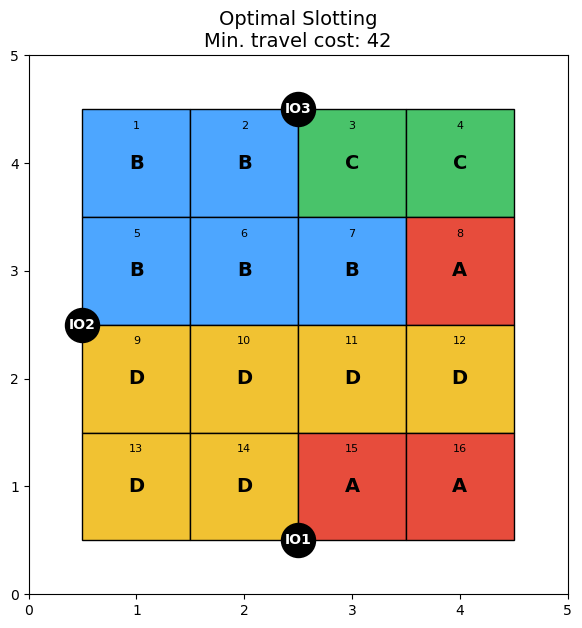

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pulp

cost_matrix = weights_matrix.astype(float)
slot_list = sorted(storage_locations.keys())


#MILP
# Decision: x[i,j] in {0,1}
x = pulp.LpVariable.dicts("x", (items, slot_list), cat="Binary")

prob = pulp.LpProblem("Slotting_MILP_with_weights", pulp.LpMinimize)

# Objective: minimize sum_{i,j} cost_matrix[i,j] * x[i,j]
prob += pulp.lpSum(cost_matrix.loc[i, j] * x[i][j] for i in items for j in slot_list)

# Constraint 1: each slot j assigned to exactly one item
for j in slot_list:
    prob += pulp.lpSum(x[i][j] for i in items) == 1

# Constraint 2: each item i occupies exactly storage_spaces[i] slots
for i in items:
    prob += pulp.lpSum(x[i][j] for j in slot_list) == storage_spaces[i]

# Solve
prob.solve(pulp.PULP_CBC_CMD(msg=0))

status = pulp.LpStatus[prob.status]
if status != "Optimal":
    raise RuntimeError(f"Solver did not return optimal status: {status}")

optimal_cost = pulp.value(prob.objective)

# Extract assignment
assignment = {}
for j in slot_list:
    assigned = None
    for i in items:
        val = pulp.value(x[i][j])
        if val is not None and val > 0.5:
            assigned = i
            break
    if assigned is None:
        raise RuntimeError(f"No item assigned to slot {j} by solver")
    assignment[j] = assigned

# Output 
print("Distance matrix d_kj (IO points x slots):")
print(distance_matrix)
print("\nWeight matrix w_ij (items x slots) — used as cost matrix:")
print(weights_matrix.round(4))

print("\nOptimal total travel cost (sum of w_ij for assigned slots):", optimal_cost)
print("Assigned counts (should equal required storage spaces):", dict(Counter(assignment.values())))
print("Slot -> Item assignment:")
for s in slot_list:
    print(f"{s:2d} : {assignment[s]}")

# Plotting
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D": "#f1c232"}

fig, ax = plt.subplots(figsize=(7, 7))

# Draw storage slots
for s, (x, y) in slots.items():
    item = assignment[s]
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                              facecolor=colors[item],
                               edgecolor="black"))
    ax.text(x, y, item, ha="center", va="center", fontsize=14, weight="bold")
    ax.text(x, y+0.3, str(s), ha="center", va="bottom", fontsize=8)

# Draw IO points
for p, (ix, iy) in io_coords.items(): 
    ax.scatter(ix, iy, s=600, c="black", zorder=6) 
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center", 
            fontsize=10, fontweight="bold", zorder=7)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect("equal")
plt.title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)
plt.show()

Example optimal assignment (illustrative only):

```
Min. travel cost: 42,420
 ╔═════════════ I/O ═════╦═══════╗
 ║   A       A       A   ║   B   ║
 ╠═══════════════╦═══════╣       ║
 ║   D       D   ║   C   ║   B   ║
I/O              ║       ║       ║
 ║   D       D   ║   C   ║   B   ║
 ║               ╠═══════╝       ║
 ║   D       D   ║   B       B   ║
 ╚═════════════ I/O ═════════════╝
```

### 2. Random vs. Dedicated Policies

The answer comprises:

- Total storage for dedicated policy.
- Total storage for random policy.
- Reasoning behind the totals.

In [ ]:
import pandas as pd
import numpy as np

scheduled_receipts = {  "Period 1": {"A": 20, "B": 12,  "C": 66, "D": 22, "E": 97},
                        "Period 2": {"A": 15,  "B": 8, "C": 15, "D": 22, "E": 12},
                        "Period 3": {"A": 30,  "B": 4, "C": 16, "D": 25, "E": 88},
                        "Period 4": {"A": 12, "B": 6,  "C": 17, "D": 21, "E": 66},
                        "Period 5": {"A": 14,  "B": 7, "C": 18, "D": 18, "E": 79},
                        "Period 6": {"A": 60,  "B": 1, "C": 19, "D": 14, "E": 55},
                        "Period 7": {"A": 17, "B": 12,  "C": 15, "D": 23, "E": 9},
                        "Period 8": {"A": 20,  "B": 40, "C": 16, "D": 36, "E": 25},
                        "Period 9": {"A": 21,  "B": 13, "C": 17, "D": 30, "E": 96},
                        "Period 10": {"A": 22, "B": 12, "C": 18, "D": 22, "E": 90},
                        "Period 11": {"A": 23,  "B": 12, "C": 19, "D": 89, "E": 90},
                        "Period 12": {"A": 23,  "B": 12, "C": 15, "D": 22, "E": 88},

}
scheduled_receipts_df = pd.DataFrame(scheduled_receipts).loc[["A", "B", "C", "D", "E"]]

# Safety stock calculation
safety_pct = 0.1 
next_period = scheduled_receipts_df.shift(-1, axis=1, fill_value=0)
safety_stock = np.ceil(safety_pct * next_period).astype(int)

# Calculate required storage spaces S_i
required_storage = scheduled_receipts_df + safety_stock

# Random policy
total_random = required_storage.values.sum(axis=0)
random_policy = int(np.ceil(total_random.max()))

# Dedicated policy
max_inventory = required_storage.max(axis=1)
dedicated_policy = int(np.ceil(max_inventory.sum()))

print("=== Scheduled Receipts ===")
print(scheduled_receipts_df, "\n")

print("=== Safety Stock ===")
print(safety_stock, "\n")

print("=== Required per Period (spaces) ===")
print(required_storage.astype(int), "\n")

print("=== Dedicated Storage Calculation ===")
print("Peak by item (spaces):")
print(max_inventory.astype(int))
print(f"\nDedicated storage spaces required: {dedicated_policy}")

print("\n=== Random Storage Calculation ===")
print("Total required spaces by period:")
print(total_random.astype(int))
print(f"\nRandom storage spaces required: {random_policy}")

=== Scheduled Receipts ===
   Period 1  Period 2  Period 3  Period 4  Period 5  Period 6  Period 7  \
A        20        15        30        12        14        60        17   
B        12         8         4         6         7         1        12   
C        66        15        16        17        18        19        15   
D        22        22        25        21        18        14        23   
E        97        12        88        66        79        55         9   

   Period 8  Period 9  Period 10  Period 11  Period 12  
A        20        21         22         23         23  
B        40        13         12         12         12  
C        16        17         18         19         15  
D        36        30         22         89         22  
E        25        96         90         90         88   

=== Safety Stock ===
   Period 1  Period 2  Period 3  Period 4  Period 5  Period 6  Period 7  \
A         2         3         2         2         6         2         2   
B      